In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms

In [2]:
device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
folder = 'data_handwritten_digits'

In [3]:
df_train = pd.read_csv(f'{folder}/train_labels.csv')
df_valid = pd.read_csv(f'{folder}/valid_labels.csv')
df_test = pd.read_csv(f'{folder}/test_labels.csv')

In [4]:
class DigitsDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, df_labels, transform=None):
        self.images_dir = images_dir
        self.labels = df_labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_file = os.path.join(self.images_dir, self.labels.iloc[idx, 0])
        img = Image.open(img_file)
        label = self.labels.iloc[idx, 1]

        if self.transform:
            img = self.transform(img)

        return img, label

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

In [5]:
train_dataset = DigitsDataset(f'{folder}/train', df_train, data_transforms['train'])
valid_dataset = DigitsDataset(f'{folder}/valid', df_valid, data_transforms['valid'])
test_dataset = DigitsDataset(f'{folder}/test', df_test, data_transforms['test'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
len(train_loader), len(valid_loader), len(test_loader)

(270, 34, 34)

In [7]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [8]:
class DigitsNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=4, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(1)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [9]:
def train_epoch(model, train_loader, criterion, optimizer):

    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        acc = accuracy(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += acc.item()

    train_loss = running_loss / len(train_loader)
    train_acc = running_acc / len(train_loader)    
    return train_loss, train_acc

def validate_epoch(model, valid_loader, criterion):

    model.eval()
    running_loss = 0.0
    running_acc = 0.0

    with torch.no_grad():
        for i, (images, labels) in enumerate(valid_loader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)

            running_loss += loss.item()
            running_acc += acc.item()

    val_loss = running_loss / len(valid_loader)
    val_acc = running_acc / len(valid_loader)
    return val_loss, val_acc

def test_model(model, test_loader):

    model.eval()
    running_acc = 0.0

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            acc = accuracy(outputs, labels)

            running_acc += acc.item()

    test_acc = running_acc / len(test_loader)
    return test_acc

def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs):

    metrics = {
        'epoch': [],
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': []
    }
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        valid_loss, valid_acc = validate_epoch(model, valid_loader, criterion)

        metrics['epoch'].append(epoch+1)
        metrics['train_loss'].append(train_loss)
        metrics['train_acc'].append(train_acc)
        metrics['valid_loss'].append(valid_loss)
        metrics['valid_acc'].append(valid_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')

    return metrics

In [10]:
model = DigitsNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

metrics = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10, Train Loss: 1.9242, Train Acc: 0.5338, Valid Loss: 1.6585, Valid Acc: 0.8100
Epoch 2/10, Train Loss: 1.6325, Train Acc: 0.8317, Valid Loss: 1.6066, Valid Acc: 0.8565
Epoch 3/10, Train Loss: 1.6022, Train Acc: 0.8604, Valid Loss: 1.5900, Valid Acc: 0.8708
Epoch 4/10, Train Loss: 1.5853, Train Acc: 0.8770, Valid Loss: 1.5515, Valid Acc: 0.9159
Epoch 5/10, Train Loss: 1.5165, Train Acc: 0.9475, Valid Loss: 1.5131, Valid Acc: 0.9472
Epoch 6/10, Train Loss: 1.4949, Train Acc: 0.9682, Valid Loss: 1.5117, Valid Acc: 0.9512
Epoch 7/10, Train Loss: 1.4876, Train Acc: 0.9744, Valid Loss: 1.5001, Valid Acc: 0.9631
Epoch 8/10, Train Loss: 1.4810, Train Acc: 0.9813, Valid Loss: 1.4894, Valid Acc: 0.9718
Epoch 9/10, Train Loss: 1.4788, Train Acc: 0.9829, Valid Loss: 1.4887, Valid Acc: 0.9726
Epoch 10/10, Train Loss: 1.4758, Train Acc: 0.9865, Valid Loss: 1.4851, Valid Acc: 0.9777


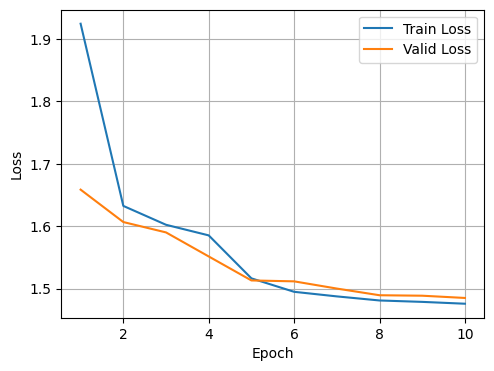

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(metrics['epoch'], metrics['train_loss'], label='Train Loss')
plt.plot(metrics['epoch'], metrics['valid_loss'], label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

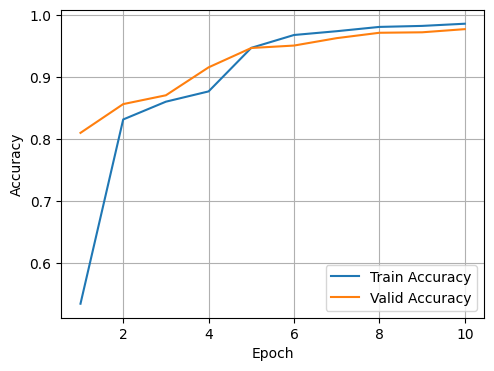

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(metrics['epoch'], metrics['train_acc'], label='Train Accuracy')
plt.plot(metrics['epoch'], metrics['valid_acc'], label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

In [13]:
test_acc = test_model(model, test_loader)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9772


In [14]:
torch.save(model.state_dict(), 'model_digits.pth')

In [15]:
model = DigitsNet().to(device)
model.load_state_dict(torch.load('model_digits.pth'))

<All keys matched successfully>

In [16]:
def predict_image(model, data):
    model.eval()
    image, label = data
    with torch.no_grad():
        img = image.unsqueeze(0).to(device)
        output = model(img)
        _, pred = torch.max(output, dim=1)
        prediction = pred.item()
    
    print(f'Label: {label}, Prediction: {prediction}')
    plt.imshow(image[0], cmap='gray')
    plt.show()

Label: 0, Prediction: 0


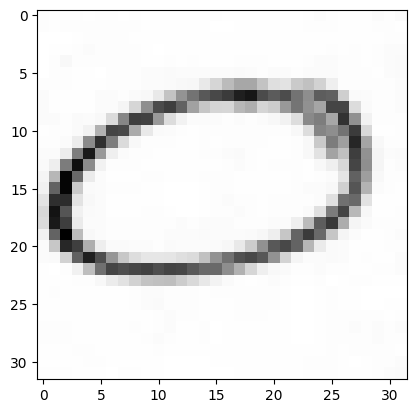

Label: 1, Prediction: 1


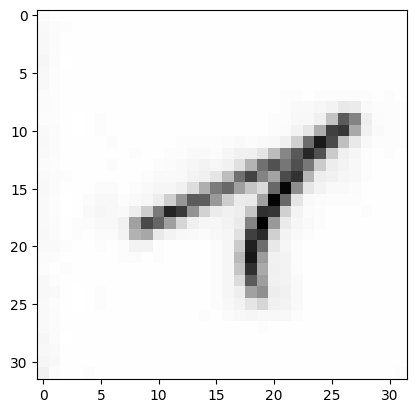

Label: 2, Prediction: 2


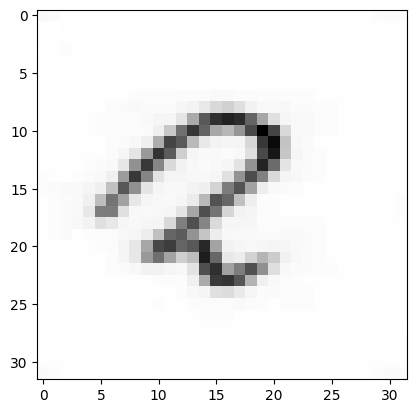

Label: 3, Prediction: 3


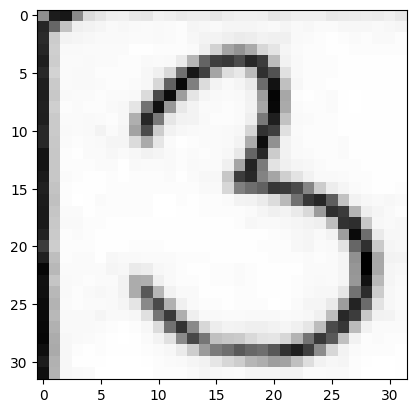

Label: 4, Prediction: 4


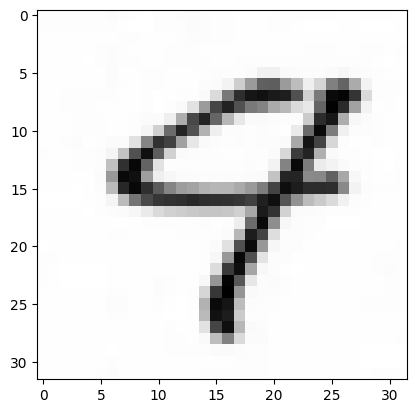

Label: 5, Prediction: 5


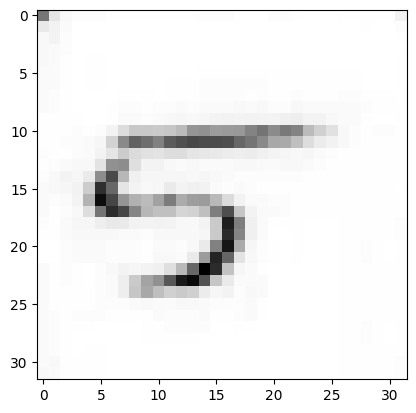

Label: 6, Prediction: 6


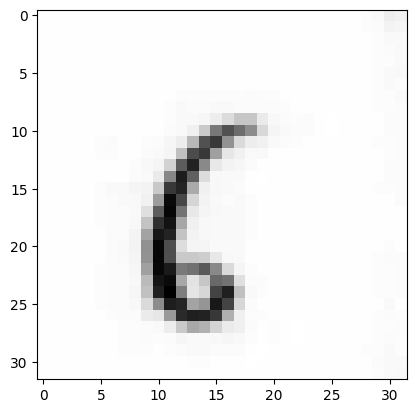

Label: 7, Prediction: 7


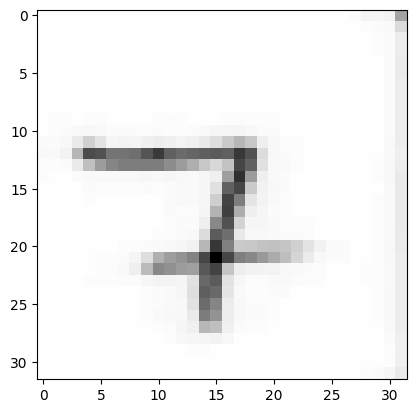

Label: 8, Prediction: 8


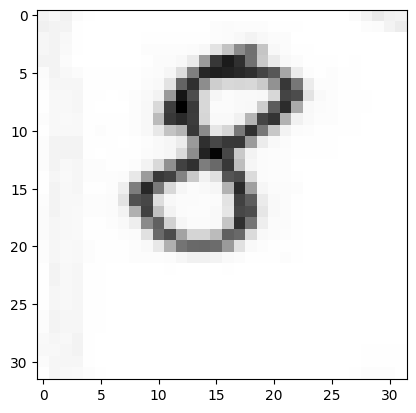

Label: 9, Prediction: 9


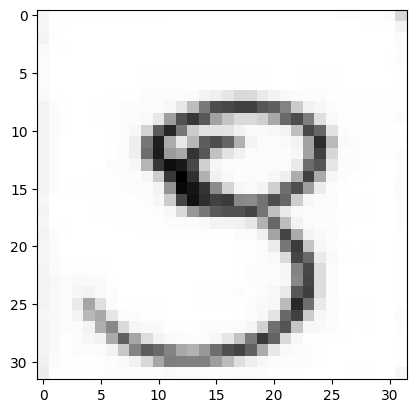

In [17]:
for idx in [100, 300, 500, 700, 900, 1200, 1400, 1600, 1800, 2000]:
    predict_image(model, test_dataset[idx])